# Comparison of dgemm calibrations w.r.t. how the matrices are generated

In these experiments, we perform calls to dgemm with three square matrices of order 2,048.

We will look at dgemm performance and the node temperatures and frequencies for different matrix generation methods:
- Setting all the elements of the matrices to some constant (either 0, 0.987 or 1, depending on the experiment)
- Setting all the elements of the matrices sequentially (buff[i] = i/n², where n is the matrix order)
- Setting all the elements of the matrices to a random number between 0 and 1

In [1]:
import io
import os
import zipfile
import pandas
import yaml
import datetime
import re
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore') # removing annoying warning
import json
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction as ae

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x):
    archive = zipfile.ZipFile(archive_name)
    df = pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    df['jobid'] = int(get_yaml(archive_name, 'info.yaml')['jobid'])
    df['index'] = range(len(df))
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

914230ba92388decf817f2c9606f3021d5d159be


In [2]:
directory = 'matrix_generation/dahu/1/'

def get_monitoring(archive_name, csv_name, min_start=None, max_stop=None):
    df = read_csv(archive_name, csv_name)
    for col in ['start', 'stop']:
        df[col] = pandas.to_datetime(df[col])
    first = df['start'].min()
    df['start'] -= first
    df['stop'] -= first
    if min_start is not None:
        old_len = len(df)
        df = df[df['start'] >= pandas.to_timedelta(min_start, unit='s')]
#        print('Archive %s: removed %d entries that happened before time %.2f s' % (archive_name, old_len-len(df), min_start))
    if max_stop is not None:
        old_len = len(df)
        df = df[df['stop'] <= pandas.to_timedelta(max_stop, unit='s')]
#        print('Archive %s: removed %d entries that happened after time %.2f s' % (archive_name, old_len-len(df), max_stop))
    if min_start is not None:
        first = df['start'].min()
        df['start'] -= first
        df['stop'] -= first
    return df

def read_archive(archive_name):
    df = read_csv(archive_name, 'result.csv')
    df['start'] = df['timestamp']
    df['end'] = df['start'] + df['duration']
    df['mnk'] = df['m'] * df['n'] * df['k']
    df['gflops'] = 2*df['mnk'] / df['duration'] * 1e-9
    core_mapping = ae.platform_to_cpu_mapping(ae.get_platform(archive_name))
    df['cpu'] = df.apply(lambda row: core_mapping[row.core], axis=1)
    info = get_yaml(archive_name, 'info.yaml')
    installfile = info['installfile']
    matrix_init = get_yaml(archive_name, installfile)['matrix_initialization']
    hosts = [key for key in info.keys() if key.endswith('grid5000.fr')]
    assert len(hosts) == 1
    host = hosts[0]
    start_time = df['start'].min()
    stop_time = df['end'].max()
    df['start'] -= start_time
    df['end'] -= start_time
    temperature = get_monitoring(archive_name, 'monitoring_temp.csv', start_time, stop_time)
    temperature['cpu'] = temperature['sensor_id']
    frequencies = get_monitoring(archive_name, 'monitoring_freq.csv', start_time, stop_time)
    frequencies['frequency'] *= 1e-9
    frequencies = frequencies[frequencies['core_id'] < len(df.core.unique())]  # removing the hyperthread cores
    frequencies['cpu'] = frequencies.apply(lambda row: core_mapping[row.core_id], axis=1)
    for tmp in [df, temperature, frequencies]:
        tmp['matrix_content'] = matrix_init
        tmp['host'] = host
    return df, temperature, frequencies

dataframes = []
cluster = set()
for filename in os.listdir(directory):
    if not filename.endswith('.zip'):
        continue
    path = os.path.join(directory, filename)
    cluster.add(get_yaml(path, 'info.yaml')['cluster'])
    dataframes.append(read_archive(path))
assert len(cluster) == 1
cluster = cluster.pop()

performance = pandas.concat([t[0] for t in dataframes])
temperature = pandas.concat([t[1] for t in dataframes])
frequency   = pandas.concat([t[2] for t in dataframes])
performance.head()

,function,m,n,k,lda,ldb,ldc,timestamp,duration,core,jobid,index,start,end,mnk,gflops,cpu,matrix_content,host
0,dgemm,2048,2048,2048,2048,2048,2048,315.218921,0.630793,0,1889753,0,35.097391,35.728184,8589934592,27.235356,0,0,dahu-25.grenoble.grid5000.fr
1,dgemm,2048,2048,2048,2048,2048,2048,315.849734,0.615753,0,1889753,1,35.728204,36.343957,8589934592,27.900585,0,0,dahu-25.grenoble.grid5000.fr
2,dgemm,2048,2048,2048,2048,2048,2048,316.465496,0.631184,0,1889753,2,36.343966,36.975150,8589934592,27.218480,0,0,dahu-25.grenoble.grid5000.fr
3,dgemm,2048,2048,2048,2048,2048,2048,317.096687,0.629217,0,1889753,3,36.975157,37.604375,8589934592,27.303546,0,0,dahu-25.grenoble.grid5000.fr
4,dgemm,2048,2048,2048,2048,2048,2048,317.725913,0.626443,0,1889753,4,37.604383,38.230825,8589934592,27.424495,0,0,dahu-25.grenoble.grid5000.fr


In [3]:
temperature.head()

,hostname,start,stop,sensor_id,temperature,jobid,index,cpu,matrix_content,host
560,dahu-25.grenoble.grid5000.fr,00:00:00,00:00:00.000252,0,74.0,1889753,560,0,0,dahu-25.grenoble.grid5000.fr
561,dahu-25.grenoble.grid5000.fr,00:00:00,00:00:00.000252,1,61.0,1889753,561,1,0,dahu-25.grenoble.grid5000.fr
562,dahu-25.grenoble.grid5000.fr,00:00:01.003593,00:00:01.003849,0,74.0,1889753,562,0,0,dahu-25.grenoble.grid5000.fr
563,dahu-25.grenoble.grid5000.fr,00:00:01.003593,00:00:01.003849,1,61.0,1889753,563,1,0,dahu-25.grenoble.grid5000.fr
564,dahu-25.grenoble.grid5000.fr,00:00:02.007250,00:00:02.007525,0,74.0,1889753,564,0,0,dahu-25.grenoble.grid5000.fr


In [4]:
frequency.head()

,hostname,start,stop,core_id,frequency,jobid,index,cpu,matrix_content,host
17920,dahu-25.grenoble.grid5000.fr,0 days,00:00:00.001996,0,2.186389,1889753,17920,0,0,dahu-25.grenoble.grid5000.fr
17921,dahu-25.grenoble.grid5000.fr,0 days,00:00:00.001996,1,2.399926,1889753,17921,1,0,dahu-25.grenoble.grid5000.fr
17922,dahu-25.grenoble.grid5000.fr,0 days,00:00:00.001996,2,2.186389,1889753,17922,0,0,dahu-25.grenoble.grid5000.fr
17923,dahu-25.grenoble.grid5000.fr,0 days,00:00:00.001996,3,2.399926,1889753,17923,1,0,dahu-25.grenoble.grid5000.fr
17924,dahu-25.grenoble.grid5000.fr,0 days,00:00:00.001996,4,2.190618,1889753,17924,0,0,dahu-25.grenoble.grid5000.fr


## Performance

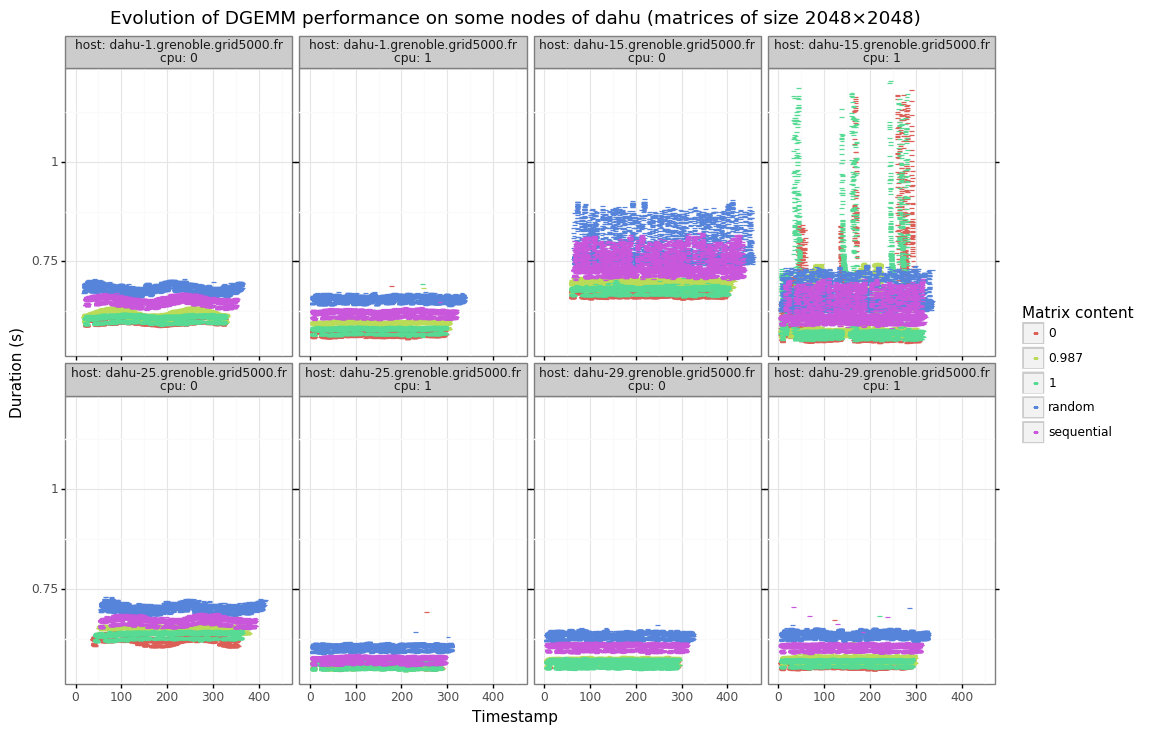

<ggplot: (-9223363292743256197)>

In [5]:
plot = ggplot(performance, aes(x='start', y='duration', color='matrix_content')) + theme_bw()
plot = plot + geom_point(shape=1) + facet_wrap(['host', 'cpu'], labeller='label_both', ncol=4)
plot = plot + xlab('Timestamp') + ylab('Duration (s)') + labs(color='Matrix content')
plot = plot + ggtitle('Evolution of DGEMM performance on some nodes of %s (matrices of size 2048×2048)' % cluster)
plot

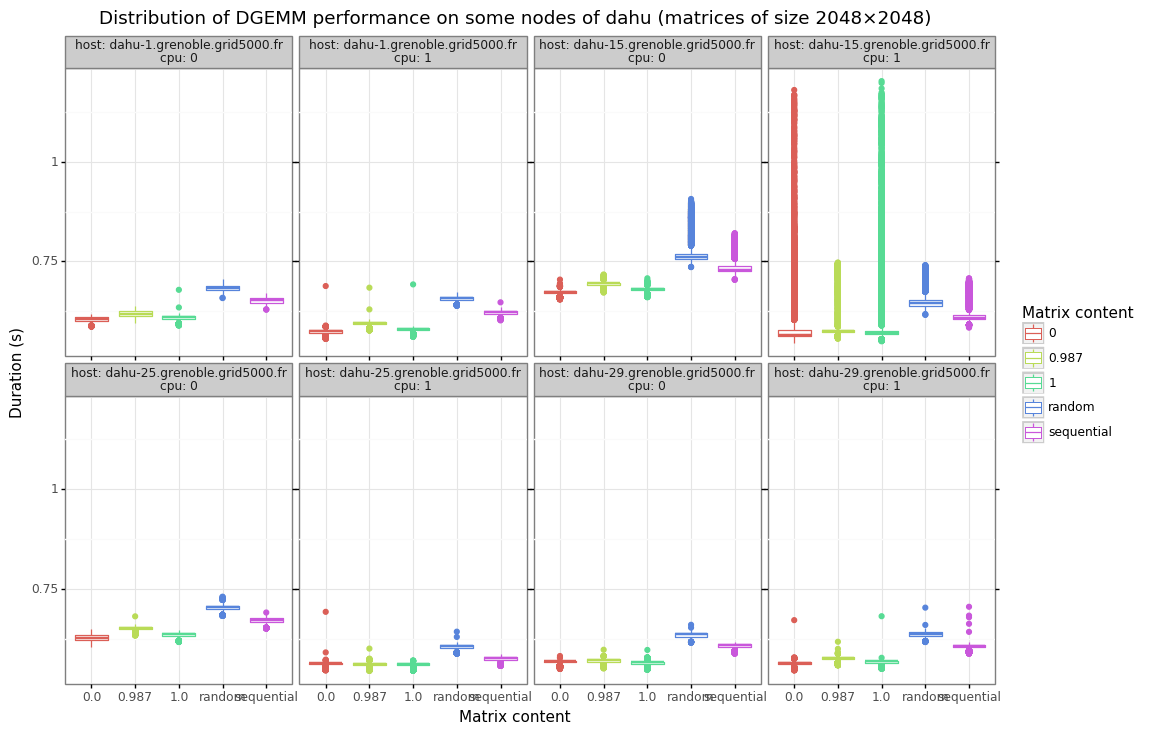

<ggplot: (-9223363292767644693)>

In [6]:
plot = ggplot(performance, aes(x='matrix_content', y='duration', color='matrix_content')) + theme_bw()
plot = plot + geom_boxplot() + facet_wrap(['host', 'cpu'], labeller='label_both', ncol=4)
plot = plot + xlab('Matrix content') + ylab('Duration (s)') + labs(color='Matrix content')
plot = plot + ggtitle('Distribution of DGEMM performance on some nodes of %s (matrices of size 2048×2048)' % cluster)
plot

In [7]:
aggr = performance.groupby(['host', 'cpu', 'matrix_content'])[['duration']].mean()
aggr

duration
host                         cpu matrix_content          
dahu-1.grenoble.grid5000.fr  0   0               0.604974
                                 0.987           0.618696
                                 1               0.607762
                                 random          0.683388
                                 sequential      0.652413
                             1   0               0.573643
                                 0.987           0.593638
                                 1               0.578621
                                 random          0.657599
                                 sequential      0.621400
dahu-15.grenoble.grid5000.fr 0   0               0.672820
                                 0.987           0.693065
                                 1               0.678744
                                 random          0.774613
                                 sequential      0.737273
                             1   0               0.601022
                                 0.987           0.586449
                                 1               0.609564
                                 random          0.653680
                                 sequential      0.618168
dahu-25.grenoble.grid5000.fr 0   0               0.626738
                                 0.987           0.651028
                                 1               0.635792
                                 random          0.703510
                                 sequential      0.670912
                             1   0               0.561429
                                 0.987           0.560705
                                 1               0.559986
                                 random          0.605457
                                 sequential      0.574641
dahu-29.grenoble.grid5000.fr 0   0               0.566438
                                 0.987           0.569314
                                 1               0.564083
                                 random          0.634957
                                 sequential      0.606588
                             1   0               0.563428
                                 0.987           0.575046
                                 1               0.566382
                                 random          0.637291
                                 sequential      0.605474

In [8]:
norandom = performance[performance.matrix_content != 'random'].groupby(['host', 'cpu'])[['duration']].mean()
random   = performance[performance.matrix_content == 'random'].groupby(['host', 'cpu'])[['duration']].mean()
random['duration_norandom'] = norandom.duration
random['diff_percent'] = (random['duration'] - random['duration_norandom'])/random['duration_norandom'] * 100
random

duration  duration_norandom  diff_percent
host                         cpu                                           
dahu-1.grenoble.grid5000.fr  0    0.683388           0.620961     10.053233
                             1    0.657599           0.591826     11.113570
dahu-15.grenoble.grid5000.fr 0    0.774613           0.695475     11.378839
                             1    0.653680           0.603801      8.260895
dahu-25.grenoble.grid5000.fr 0    0.703510           0.646118      8.882705
                             1    0.605457           0.564190      7.314368
dahu-29.grenoble.grid5000.fr 0    0.634957           0.576606     10.119706
                             1    0.637291           0.577583     10.337666

## Temperature

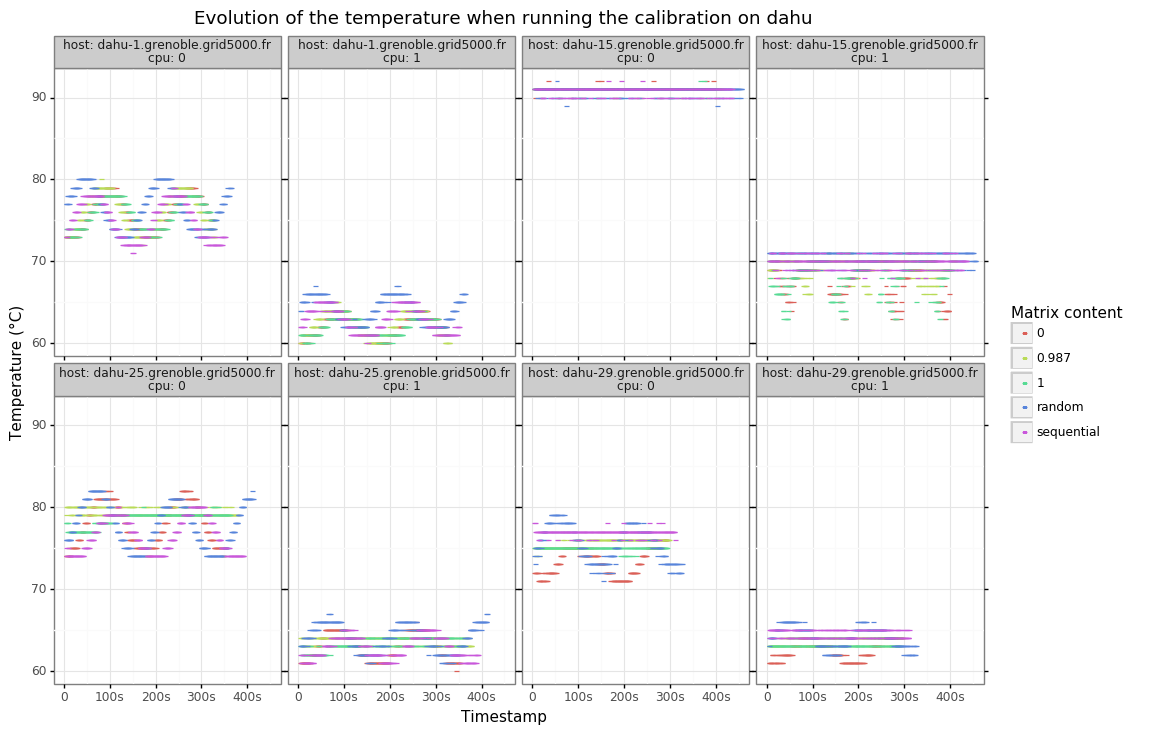

<ggplot: (8744085436557)>

In [9]:
plot = ggplot(temperature, aes(x='start', y='temperature', color='matrix_content')) + theme_bw()
plot = plot + geom_point(shape=1) + facet_wrap(['host', 'cpu'], labeller='label_both', ncol=4)
plot = plot + xlab('Timestamp') + ylab('Temperature (°C)') + labs(color='Matrix content')
plot = plot + ggtitle('Evolution of the temperature when running the calibration on %s' % cluster)
plot

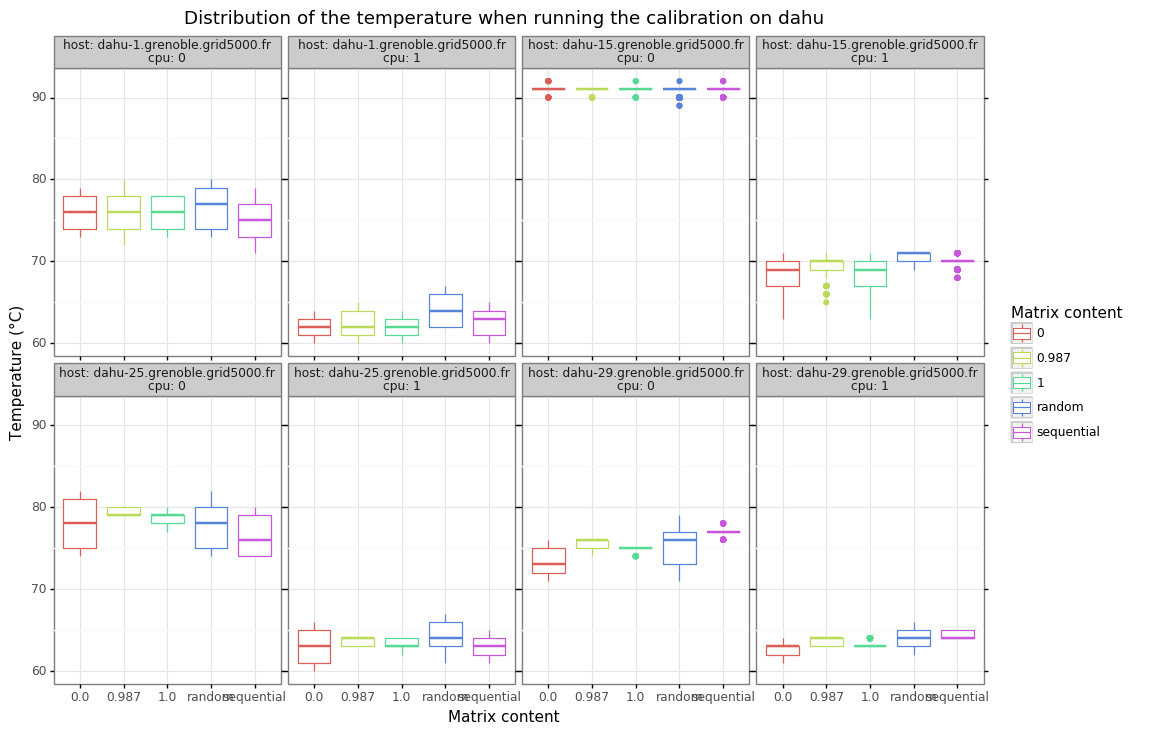

<ggplot: (8744111305206)>

In [10]:
plot = ggplot(temperature, aes(x='matrix_content', y='temperature', color='matrix_content')) + theme_bw()
plot = plot + geom_boxplot() + facet_wrap(['host', 'cpu'], labeller='label_both', ncol=4)
plot = plot + xlab('Matrix content') + ylab('Temperature (°C)') + labs(color='Matrix content')
plot = plot + ggtitle('Distribution of the temperature when running the calibration on %s' % cluster)
plot

## Frequency

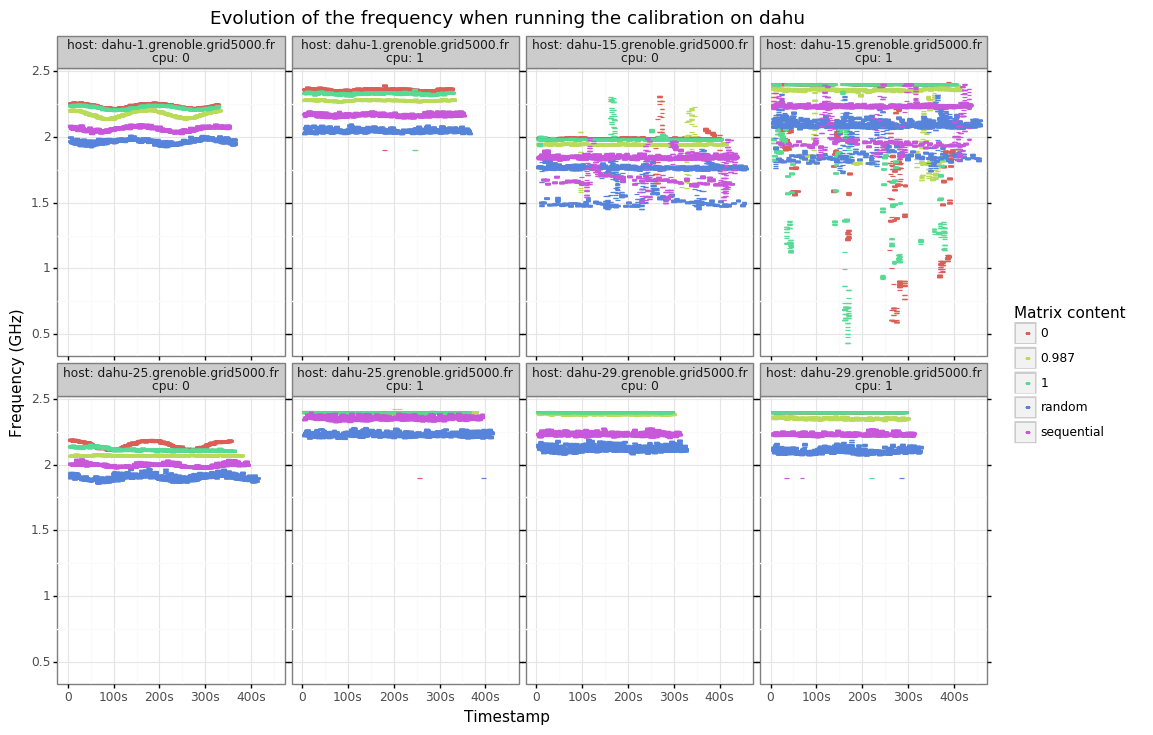

<ggplot: (-9223363292769378174)>

In [11]:
plot = ggplot(frequency, aes(x='start', y='frequency', color='matrix_content')) + theme_bw()
plot = plot + geom_point(shape=1) + facet_wrap(['host', 'cpu'], labeller='label_both', ncol=4)
plot = plot + xlab('Timestamp') + ylab('Frequency (GHz)') + labs(color='Matrix content')
plot = plot + ggtitle('Evolution of the frequency when running the calibration on %s' % cluster)
plot

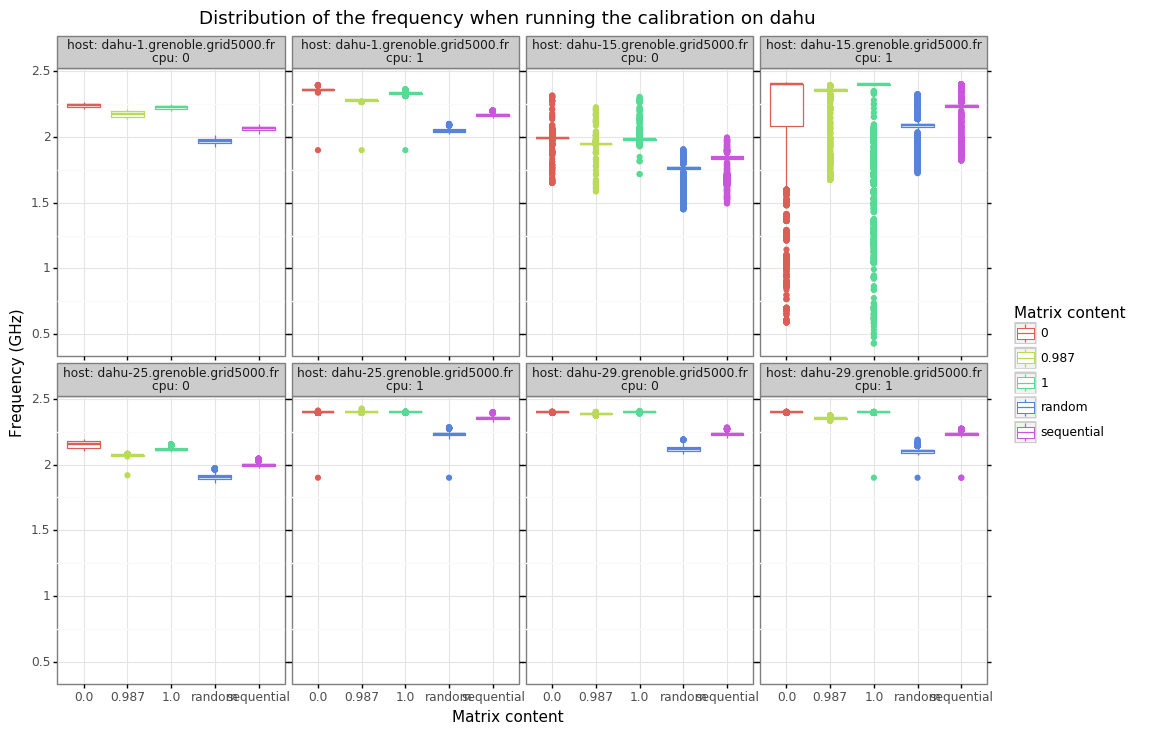

<ggplot: (8744100997531)>

In [12]:
plot = ggplot(frequency, aes(x='matrix_content', y='frequency', color='matrix_content')) + theme_bw()
plot = plot + geom_boxplot() + facet_wrap(['host', 'cpu'], labeller='label_both', ncol=4)
plot = plot + xlab('Matrix content') + ylab('Frequency (GHz)') + labs(color='Matrix content')
plot = plot + ggtitle('Distribution of the frequency when running the calibration on %s' % cluster)
plot